# Demo de implementación de un algoritmo de Programación Genética para obtener una fórmula matemática que se aproxime al comportamiento de un conjunto de datos
Ejemplo adaptado de https://deap.readthedocs.io/en/master/examples/gp_symbreg.html
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

0) Preparar el ambiente:

In [6]:
!pip install deap

1) Importar librerías:

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

import operator
import math

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

print("\nLibrerías importadas")


Librerías importadas


2) Definir los Datos (ENTRADA y SALIDA) para que intente aproximar la fórmula correspondiente:

In [8]:
# Para este ejemplo se trata de aproximar:  x al cubo más 1
ENTRADA = range(100)
SALIDA = []
for x in ENTRADA:
  SALIDA.append( x**3 + 1 )

print("Entradas: ", list(ENTRADA))
print("Salidas: ", SALIDA)

Entradas:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Salidas:  [1, 2, 9, 28, 65, 126, 217, 344, 513, 730, 1001, 1332, 1729, 2198, 2745, 3376, 4097, 4914, 5833, 6860, 8001, 9262, 10649, 12168, 13825, 15626, 17577, 19684, 21953, 24390, 27001, 29792, 32769, 35938, 39305, 42876, 46657, 50654, 54873, 59320, 64001, 68922, 74089, 79508, 85185, 91126, 97337, 103824, 110593, 117650, 125001, 132652, 140609, 148878, 157465, 166376, 175617, 185194, 195113, 205380, 216001, 226982, 238329, 250048, 262145, 274626, 287497, 300764, 314433, 328510, 343001, 357912, 373249, 389018, 405225, 421876, 438977, 456534, 474553, 493040, 512001, 531442, 551369, 571788, 59

3) Inicializar objetos de DEAP para utilizar y especificar Primitivas, Estructura del Cromosoma + Función de Aptitud y Operadores Genéticos:

In [0]:
## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

In [10]:
## PRIMITIVAS QUE SE VAN A UTILIZAR 
## PARA GENERAR EL ÁRBOL DE LA FÓRMULA MATEMÁTICA
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("c1", lambda: random.randint(-99,99))
pset.addEphemeralConstant("c2", lambda: random.randint(-99,99))

pset.renameArguments(ARG0='x')

print("\nPrimitivas definidas")


Primitivas definidas


In [11]:
### FUNCIÓN DE APTITUD y CROMOSOMA

# indica que es la función de aptitud es para minimizar el error
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def calculaError(individual):
    # Transforma la expresión del árbol en una función que se puede ejecutar
    func = toolbox.compile(expr=individual)
    # calcula la diferencia entre lo que devuelve la función y el valor Y
    sqerrors = ((func(x) - y)**2 for x, y in zip(ENTRADA, SALIDA))
    return math.fsum(sqerrors) / len(ENTRADA),

toolbox.register("evaluate", calculaError)

print("\nFunción de Aptitud y Cromosoma definidos")


Función de Aptitud y Cromosoma definidos


In [12]:
## OPERADORES GENÉTICOS
## (ver lista completa en https://deap.readthedocs.io/en/master/api/tools.html#operators )

# Registrar tipo de Selección a aplicar con sus parámetros
toolbox.register("select", tools.selTournament, tournsize=2)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
toolbox.register("mate", gp.cxOnePoint)

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# define parámetros adicionales para evitar el BLOAT
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [13]:
### Parámetros de la Corrida

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 100

# Indica que finaliza corrida cuando se alcance una  Diferencia Máxima (opcional)
FINALIZA_CORRIDA_POR_MAX_APTITUD = True
FINALIZA_CORRIDA_VAL_MAX_APTITUD = 0.1

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 30

# Probabilidad del Cruzamiento (en AG 1 = 100%)
PROBAB_CRUZAMIENTO = 1 

# Probabilidad del Mutación 
PROBAB_MUTACION = 0.2

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


In [14]:
## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra):
    
    auxMax = indivPobla[0].fitness.values[0]
    auxMin = indivPobla[0].fitness.values[0]
    auxSum = indivPobla[0].fitness.values[0]
    auxBestInd = indivPobla[0]
    for ind in indivPobla[1:]:

        apt = ind.fitness.values[0]
        auxSum = auxSum + apt

        if apt > auxMax:
            auxMax = apt            

        if apt < auxMin:
            auxMin = apt
            auxBestInd = ind

    auxProm = auxSum / len(indivPobla)

    if muestra:          
        print("\n-- Ciclo  %i --" % ciclo)
        print(" Mejor Individuo:", auxBestInd)
        print("   Max: ", auxMax, " / Promedio: ", round(auxProm,2), " / Min: ", auxMin)

    return auxBestInd, auxMax, auxProm, auxMin

print("\nFunción {CalculoEstadisticas} definida")   


Función {CalculoEstadisticas} definida


In [15]:
## EJECUCIÓN DE LA CORRIDA

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
fitnesses = list(map(toolbox.evaluate, indivPobla))
for ind, fit in zip(indivPobla, fitnesses):
    ind.fitness.values = fit

# vectores auxiliares 
ciclo = 1    
ciclosMinIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS)
ciclosMinIndiv.append( auxBestInd )
ciclosMaxAptitud.append( auxMax )
ciclosPromAptitud.append( auxProm )
ciclosMinAptitud.append( auxMin )

        # criterio de paro
while (ciclo < CANT_CICLOS) and (not(FINALIZA_CORRIDA_POR_MAX_APTITUD) or (auxMin > FINALIZA_CORRIDA_VAL_MAX_APTITUD)):

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, len(indivPobla))

    # Inicializa a los hijos clonando a los seleccionados
    indivHijos = list(map(toolbox.clone, indivSelecc))
    
    # Realiza el Cruzamiento
    for hijo1, hijo2 in zip(indivHijos[::2], indivHijos[1::2]):
        if random.random() < PROBAB_CRUZAMIENTO:
            toolbox.mate(hijo1, hijo2)
            del hijo1.fitness.values
            del hijo2.fitness.values

    # Realiza la Mutación
    for mutant in indivHijos:
        if random.random() < PROBAB_MUTACION:
            toolbox.mutate(mutant)
            del mutant.fitness.values
              
    # Evalua a los individuos que salen de la Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Reemplaza la población actual con los hijos
    indivPobla[:] = indivHijos
    
    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS)
    ciclosMinIndiv.append( auxBestInd )
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --" % ciclo )

mejorCiclo = np.argmin( ciclosMinAptitud )

print("\n== Mejor Individuo de la Corrida:", ciclosMinIndiv[mejorCiclo], " ( ", ciclosMinAptitud[mejorCiclo], " ) ==")


-- Ciclo  0 --
 Mejor Individuo: add(add(x, x), sub(x, -82))
   Max:  142363156113.00372  / Promedio:  138145786320.3  / Min:  137750487310.2

-- Ciclo  1 --
 Mejor Individuo: mul(x, x)
   Max:  140181565135.3  / Promedio:  137894038900.33  / Min:  134692961357.8

-- Ciclo  2 --
 Mejor Individuo: add(add(x, x), sub(x, -82))
   Max:  139198430237.8  / Promedio:  137967992536.24  / Min:  137750487310.2

-- Ciclo  3 --
 Mejor Individuo: add(add(29, sub(x, -82)), sub(x, -82))
   Max:  137977492342.19257  / Promedio:  137880001652.76  / Min:  137735126271.3

-- Ciclo  4 --
 Mejor Individuo: add(add(add(29, sub(x, -82)), x), sub(x, -82))
   Max:  138030009691.32  / Promedio:  137869236968.07  / Min:  137696155030.2

-- Ciclo  5 --
 Mejor Individuo: add(protectedDiv(x, -81), sub(mul(x, x), neg(23)))
   Max:  137986350082.6  / Promedio:  137740817723.86  / Min:  134682317219.19676

-- Ciclo  6 --
 Mejor Individuo: add(neg(-80), sub(mul(x, x), neg(x)))
   Max:  142293368960.1401  / Promedio:  

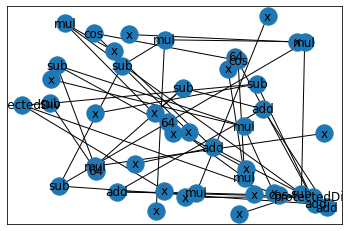

In [18]:
## MOSTRAR GRAFICO DE LA EXPRESIÓN 
## CORRESPONDIENTE AL MEJOR INDIVIDUO 
nodes, edges, labels = gp.graph( ciclosMinIndiv[mejorCiclo] )

g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

pos = nx.random_layout(g)

nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)

plt.show()

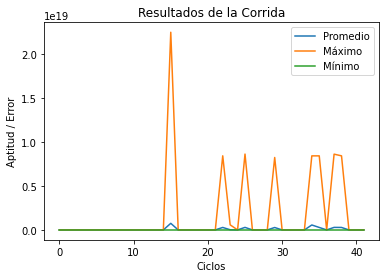

In [19]:
## MOSTRAR GRAFICO DE LA CORRIDA
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMaxAptitud)
plt.plot(ciclosMinAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud / Error')
plt.legend(['Promedio', 'Máximo', 'Mínimo'], loc='upper right')

plt.show()